
# PARNASSE ROMARIC STANCE DETECTION

<p style="text-align:center; text-transform:uppercase;">Bibliothèque utilisé lors de ce stage</p>

In [1]:
#!pip install --upgrade pandas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nltk
import groq
from tqdm import tqdm
#key=votre key
import torch
import transformers
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from transformers import pipeline

/var/folders/pv/fql_h__s6_j6_jjpd2gr9kk40000gn/T/ipykernel_28205/4191622482.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


ModuleNotFoundError: No module named 'seaborn'

Chargement des données(***en bloc***) dans un data frame chaque ligne corespond à chaque commentaire
Sous le format ID,DATE,GENRE,TEXT


In [23]:
data = pd.DataFrame(columns=['id', 'date', 'genre'])

# Parcourir les fichiers de 1 à 2299
for i in range(1, 2300):
    filename = f"{i}.txt"
    with open(filename, "r") as file:
        # Lire les lignes
        lines = file.readlines()
        # Extraire les informations
        text = lines[2].strip()
        genre = lines[1].strip()
        date = lines[0].strip()
        
        

        # Créer un nouveau DataFrame avec une ligne
        new_data = pd.DataFrame([{'id': i, 'text': text,'date': date, 'genre': genre}])

        # Concaténer les deux DataFrames
        data = pd.concat([data, new_data], ignore_index=True)

data['pre_target']=None
data['pre_granualité']=None
data.to_csv('DataSet.entier.csv')

In [24]:
data

,id,date,genre,text,pre_target,pre_granualité
0,1,20/02/2020,Femme,Ma garde au samu social à été très enrichissan...,None,None
1,2,18/02/2020,Femme,"A propos de la double écoute, j’étais placé au...",None,None
2,3,13/02/2020,Femme,Expérience très enrichissante pour une/une fut...,None,None
3,4,12/02/2020,Femme,J'arrive au Samu social et me retrouve face à ...,None,None
4,5,12/02/2020,Homme,J'ai trouvé cette expérience très enrichissant...,None,None
...,...,...,...,...,...,...
2294,2295,22/05/2011,Homme,"Initialement, j'étais assez sceptique par rapp...",None,None
2295,2296,20/05/2011,Femme,"Ce fut une nuit très mouvementée, et éprouvant...",None,None
2296,2297,17/05/2011,Femme,Ce qui m'a marqué en premier lieu c'est de voi...,None,None
2297,2298,13/05/2011,Homme,La Garde au SAMU SOCIAL de Paris a été l’une d...,None,None


Chargement des données(***par phrase***) dans un data frame chaque ligne corespond à chaque commentaire.
Sous le format ID,DATE,GENRE,TEXT

In [29]:
#J'ai ajouté les id des bloc pour pouvoir les retrouver quand cela sera nécéssaire 
# Téléchargez les ressources nécessaires pour tokenizer les phrases
nltk.download('punkt')

# Créez une liste vide pour stocker les données de chaque fichier
all_data = []

for i in range(1, 2300):
    # Utilisez la fonction format() pour créer le nom du fichier à partir du nombre i
    filename = "{}.txt".format(i)
    
    # Vérifiez si le fichier existe avant d'essayer de l'ouvrir
    if os.path.exists(filename):
        with open(filename, "r") as f:
            # Lisez la date et le genre
            date = f.readline().strip()
            genre = f.readline().strip()
            # Lisez les commentaires restants
            text = f.read().strip()
            
            # Utilisez nltk pour diviser le texte en phrases
            sentences = nltk.sent_tokenize(text)
            
            # Créez un dictionnaire pour chaque phrase
            for sentence in sentences:
                data_dict = {"date": date, "genre": genre, "text": sentence, "Id_bloc": i}
                all_data.append(data_dict)

# Une fois que tous les fichiers ont été traités et que les données ont été stockées dans la liste all_data
# On crée le DataFrame en conséquent 
df_phrase = pd.DataFrame(all_data)

# On formate au format standard de date
try:
    df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y")
except ValueError as e:
    print(f"Erreur de conversion de date : {e}")
    # Gérez l'erreur comme nécessaire, par exemple en remplaçant les dates incorrectes par NaT
    df["date"] = pd.to_datetime(df["date"], errors='coerce', format="%d/%m/%Y")

# On transforme la colonne genre en str
df_phrase["genre"] = df_phrase["genre"].astype(str)

# Créez une série de nombres entiers à partir de 0 pour les IDs
df_phrase["id"] = range(len(df))

# Réorganisez les colonnes du DataFrame
df_phrase = df_phrase[["id", "genre", "text", "date", "Id_bloc"]]

# Affichez les premières lignes pour vérifier
print(len(df_phrase))

# Sauvegardez le DataFrame dans un fichier CSV
df_phrase['pre_annot']=None
df_phrase['granualité']=None
df_phrase.to_csv("DataSet_phrase_entier.csv", index=False)

[nltk_data] Downloading package punkt to /Users/ippo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


13756


In [49]:
# Diviser le DataFrame en deux parties 80 pour le train et 20 pour le test
data_80, data_20 = train_test_split(data, test_size=0.2, random_state=42)
phrase_80, phrase_20 = train_test_split(df_phrase, test_size=0.2, random_state=42)
data_80.to_csv('DataSet_bloc_80.csv')
data_20.to_csv('DataSet_bloc_80.csv')
phrase_80.to_csv('DataSet_phrase_80.csv')
phrase_20.to_csv('DataSet_bloc_20.csv')
phrase_80

,id,genre,text,date,Id_bloc,pre_annot,granualité
8513,8513,Homme,Cette nuit nous confronte à la solitude des pe...,07/12/2014,1415,None,None
4215,4215,Femme,"Comme son nom l'indique, on s'axe sur le socia...",23/06/2017,717,None,None
2018,2018,Femme,J'ai été très bien intégrée par l'équipe que j...,19/09/2018,333,None,None
8121,8121,Femme,L'expérience qui m'a le plus marquée est la re...,02/03/2015,1338,None,None
3902,3902,Homme,Les équipes sont très adaptés au différentes s...,09/08/2017,654,None,None
...,...,...,...,...,...,...,...
5191,5191,Homme,- Beaucoup de très très bonnes choses dans le ...,23/10/2016,875,None,None
13418,13418,Homme,Cette garde s'est avérée très intéressante : e...,26/07/2011,2253,None,None
5390,5390,Femme,"Et quand enfin ils ont une place, le lendemain...",12/09/2016,904,None,None
860,860,Femme,"Savoir comment leur parler, comment les aborde...",27/05/2019,134,None,None


Calcul de la répartition ***Homme/Femme*** au sein du campus

In [39]:
def calcul_nb_hommes_femmes(df):
    '''Fonction pour calculer le nombre de femmes/hommes'''
    nb_hommes = 0
    nb_femmes = 0
    #On parcours la colonne genre
    for genre in df["genre"]:
        if genre == "Homme":
            nb_hommes += 1
        elif genre == "Femme":
            nb_femmes += 1
            
    return nb_hommes, nb_femmes
    
calcul_nb_hommes_femmes(data)

(858, 1441)

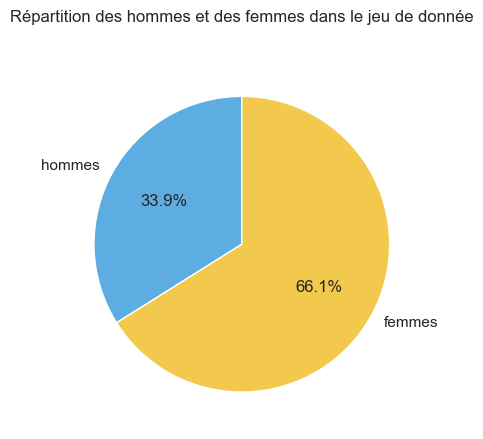

In [40]:
# Calculez le nombre d'hommes et de femmes dans le data frame df
nb_hommes,nb_femmes = calcul_nb_hommes_femmes(df)

# Calculez le pourcentage d'hommes et de femmes dans le data frame df
pourcentage_hommes = (nb_hommes / (nb_hommes + nb_femmes)) * 100
pourcentage_femmes = (nb_femmes / (nb_hommes + nb_femmes)) * 100

# Créez une liste contenant le nombre d'hommes et de femmes dans le data frame df
genre_count = [nb_hommes, nb_femmes]

# Créez une liste contenant les étiquettes pour les tranches du camembert
genre_labels = ["hommes", "femmes"]

# Créez une liste contenant les couleurs pour les tranches du camembert
genre_colors = ["#5DADE2", "#F2C94C"]

# Créez un graphe en camembert de la répartition des hommes et des femmes dans le data frame df
# en utilisant la bibliothèque seaborn et en affichant les pourcentages respectifs de chaque tranche du camembert dans le graphe
sns.set(style="whitegrid")
ax = plt.subplot(111, aspect="equal")
ax.pie(genre_count, labels=genre_labels, colors=genre_colors, autopct="%1.1f%%", startangle=90)
ax.axis("off")
plt.title("Répartition des hommes et des femmes dans le jeu de donnée", y=1.08)
plt.show()

In [50]:
client = groq.Client(api_key='votre_key')
chat_completion = client.chat.completions.create(
    messages=[
        {
             "role": "user",
             "content": f"Tu es un modèle de classification et voici la phrase : {df_phrase.loc[0, 'text']}et voici la classification : Positif , Négatif , Neutre je veux un seul mot en guise de réponse"
        }
    ],
    model="llama3-70b-8192"
)
print(df_phrase.loc[0, 'text'],chat_completion.choices[0].message.content)

Ma garde au samu social à été très enrichissante. Positif


Les modèles avce l'api dispo avec groq:
<br>De chez ***Meta***
</br>"llama3-70b-8192"
</br>"llama3-8b-8192"
</br>De chez ***Mistral***
</br>"mixtral-8x7b-32768"
</br>De chez ***Google***
</br>"gemma-7b-it"
</br>De ***OpenAi***
</br>"whisper-large-v3"

In [ ]:
client = groq.Client(api_key='votre_key')
chat_completion = client.chat.completions.create(
    messages=[
        {
             "role": "user",
             "content": f"Tu es un modèle de classification : {df_phrase.loc[2, 'text']} je veux que tu me donne la granualité de la phrase ou allant de 3 à -3 , 3 est tres positive et -3et 0 quand c'est neutre très négative je veux uniquement le résultat qui est un chiffre et rien d'autre avec aucun contexte"
        }
    ],
    model="llama3-70b-8192"
)
print(df_phrase.loc[2, 'text'],chat_completion.choices[0].message.content)

In [58]:
client = groq.Client(api_key='votre_key')
chat_completion = client.chat.completions.create(
    messages=[
        {
             "role": "user",
             "content": f"Tu es un modèle de classification : {df_phrase.loc[2, 'text']} je veux que tu me donne la granualité de la phrase ou allant de 3 à -3 , 3 est tres positive et -3et 0 quand c'est neutre très négative je veux uniquement le résultat qui est un chiffre et rien d'autre avec aucun contexte"
        }
    ],
    model="llama3-8b-8192"
)
print(df_phrase.loc[2, 'text'],chat_completion.choices[0].message.content)

Je me suis rendue compte du manque de moyens. -2


Fonction qui renvois le nombre de changement de réponsse du modèle sur une meme phrase

In [63]:
def test_model(model_nom, phrase, n_iterations=30):
    cpt = 0
    client = groq.Client(api_key="votre_key")

    # Effectuer la première requête
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": f"Tu es un modèle de classification et voici la phrase : {phrase}et voici la classification : Positif , Négatif , Neutre je veux un seul mot en guise de réponse"
            }
        ],
        model=model_nom
    )
    tmp = chat_completion.choices[0].message.content

    # Effectuer les autres requêtes
    for i in tqdm(range(n_iterations),desc='Essais'):
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": f"Tu es un modèle de classification et voici la phrase : {phrase}et voici la classification : Positif , Négatif , Neutre je veux un seul mot en guise de réponse"
                }
            ],
            model=model_nom
        )
        if tmp != chat_completion.choices[0].message.content:
            cpt += 1
        #print(tmp)
        #print(cpt)
        tmp = chat_completion.choices[0].message.content

    return cpt

# Tester le modèle
resultat = test_model("mixtral-8x7b-32768", df_phrase.iloc[0])
print(resultat)


Essais: 100%|███████████████████████████████████| 30/30 [00:42<00:00,  1.42s/it]

2


In [103]:
def test_model_gra(model_nom, phrase,n_iterations=20):
    cpt = 0
    client = groq.Client(api_key="votre_key")

    # Effectuer la première requête
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": f"Tu es un modèle de classification : {phrase} je veux que tu me donne la granualité de la phrase ou allant de 3 à -3 , 3 est tres positive et -3et 0 quand c'est neutre très négative je veux uniquement le résultat qui est un chiffre et rien d'autre avec aucun contexte"            }
        ],
        model=model_nom
    )
    tmp = chat_completion.choices[0].message.content.strip()

    # Effectuer les autres requêtes
    for i in tqdm(range(n_iterations)):
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": f"Tu es un modèle de classification : {phrase} je veux que tu me donne la granualité de la phrase ou allant de 3 à -3 , 3 est tres positive et -3et 0 quand c'est neutre très négative je veux uniquement le résultat qui est un chiffre et rien d'autre avec aucun contexte"
                }
            ],
            model=model_nom
        )
        response = chat_completion.choices[0].message.content.strip()
        if tmp != response:
            cpt += 1
        tmp = response

    return cpt
# Tester le modèle
resultat = test_model("mixtral-8x7b-32768", df_phrase.iloc[0])
print(resultat)


Essais: 100%|███████████████████████████████████| 30/30 [00:13<00:00,  2.27it/s]

0


In [ ]:
def moyenne_diff_class(df,model,n):
    sample_size = 10
    n_iterations = 3
    #sample aléatoire du data frame
    sample_data = df.sample(n=sample_size, random_state=n)

    # Initialiser un compteur pour le nombre total de différences de sortie
    total_cpt = 0

    # Tester chaque élément de l'échantillon en utilisant la fonction test_model
    for i, row in sample_data.iterrows():
        resultat = test_model(model, row, n_iterations)
        #print(f"Résultat pour l'élément {i+1} : {resultat}")
        total_cpt += resultat

    mean_diff = total_cpt / (sample_size * n_iterations)
    round(mean_diff,2)
    return mean_diff
moyenne_diff_class(df,"llama3-70b-8192",4)

In [68]:
def rep_mod(phrase,modele):
    
    client = groq.Client(api_key="votre_key")
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": f"Tu es un modèle de classification et voici la phrase : {phrase}et voici la classification : Positif , Négatif , Neutre je veux un seul mot en guise de réponse"
            }
        ],
        model=modele
    )
    return chat_completion.choices[0].message.content
    

In [226]:
def rep_mod_gra(phrase,modele):
    client = groq.Client(api_key='votre_key')
    chat_completion = client.chat.completions.create(
        messages=[
            {
                 "role": "user",
                 "content": f"Tu es un modèle de classification : {phrase} je veux que tu me donne la granualité de la phrase ou allant de 3 à -3 , 3 est tres positive et -3et 0 quand c'est neutre très négative je veux uniquement le résultat qui est un chiffre et rien d'autre avec aucun contexte"
            }
        ],
        model=modele
    )
    return chat_completion.choices[0].message.content

rep_mod_gra(df_phrase.iloc[1]['text'],"llama3-70b-8192")

'3'

In [79]:
#fonction qui renvois la réponses du modèle pour la target
def rep_mod_target(bloc,modele):
    client = groq.Client(api_key='votre_key')
    chat_completion = client.chat.completions.create(
        messages=[
            {
             "role": "user",
             "content": f"Tu es un modèle de stance detection et voici la commentaire : {bloc} Je veux que tu me donne uniquement vers quoi est dirigé la target la sans aucun contexte et rien d'autre avec précision sans explication sans depasser 5 mots dans ta réponsse de la manière la plus précise possible"
            }
        ],
        model=modele
    )
    return chat_completion.choices[0].message.content

print(data_80.iloc[690]['text'],rep_mod_target(data_80.iloc[690]['text'],"llama3-70b-8192"))

1ère étape : la double écoute. On m'avait dit que c'était la partie la moins intéressante, peut être (par rapport à la maraude; par exemple, la travailleuse sociale avec qui j'étais m'enviait de partir en maraude), mais ce n'était pas du tout ennuyeux. On m'a tout de suite bien accueillie, et bien expliqué à chaque fois la situation de l'usager qui appelait, les différentes solutions à lui proposer, son suivi.  2ème étape : le briefing. La rencontre de toutes ces personnes qui travaillent la nuit pour apporter leur aide aux plus démunis. Il m'a permis aussi de mieux comprendre l'organisation des maraudes.  3ème étape : la maraude. Avec une équipe hilarante et accueillante. Rencontre de plusieurs sans abris, un peu discuté avec l'un d'entre eux, tous très sympathiques. Pas très différents de nous finalement, on ne sait pas ce que la vie nous réserve.  J'ai été étonnée du manque de moyens dans les centres, je me souviendrais d'un soin infirmier d'une plaie du pied, avec un infirmier cons

***Pré-annotation des granualité du df_phrase80(80% du dataset)***

In [ ]:
#Pré annotation des granualité
for idx, row in tqdm(phrase_80.iterrows(), total=len(phrase_80), desc="Annotation des phrase en cours"):
    phrase_80.loc[idx, 'granualité'] = rep_mod_gra(row['text'], modele)
    
phrase_80.to_csv("training_set_annot_80.csv")

In [210]:
#Pré-annotation des classification 
modele = "llama3-70b-8192"
for idx, row in tqdm(df_phrase_80.iterrows(), total=len(phrase_80), desc="Annotation des phrase en cours"):
    phrase_80.loc[idx, 'pre_annot'] = rep_mod(row['text'], modele)


Annotation des phrase en cours:  98%|██▉| 11005/11265 [8:36:26<12:12,  2.82s/it]


In [214]:
phrase_80= phrase_80.dropna(subset=['text'])
phrase_80

,id,genre,text,date,Id_bloc,pre_annot,granualité,num_tokens
8513,8513.0,Homme,Cette nuit nous confronte à la solitude des pe...,07/12/2014,1415.0,Positif,None,10.0
4215,4215.0,Femme,"Comme son nom l'indique, on s'axe sur le socia...",23/06/2017,717.0,Positif,None,25.0
2018,2018.0,Femme,J'ai été très bien intégrée par l'équipe que j...,19/09/2018,333.0,Neutre,None,11.0
8121,8121.0,Femme,L'expérience qui m'a le plus marquée est la re...,02/03/2015,1338.0,Négatif,None,12.0
3902,3902.0,Homme,Les équipes sont très adaptés au différentes s...,09/08/2017,654.0,Négatif,None,9.0
...,...,...,...,...,...,...,...,...
5191,5191.0,Homme,- Beaucoup de très très bonnes choses dans le ...,23/10/2016,875.0,Positif,None,157.0
13418,13418.0,Homme,Cette garde s'est avérée très intéressante : e...,26/07/2011,2253.0,None,None,42.0
5390,5390.0,Femme,"Et quand enfin ils ont une place, le lendemain...",12/09/2016,904.0,Positif,None,14.0
860,860.0,Femme,"Savoir comment leur parler, comment les aborde...",27/05/2019,134.0,Positif,None,21.0


***Pré-annotation des target du data_80(80%du dataset)***

In [211]:
#Pré annotation des Target
for idx, row in tqdm(data_80.iterrows(), total=len(data_80), desc="Annotation des target en cours"):
    data_80.loc[idx, 'target'] = rep_mod_target(row['text'], modele)
data_80

Annotation des target en cours: 100%|█████| 1839/1839 [1:34:07<00:00,  3.07s/it]


,id,date,genre,text,pre_target,pre_granualité,num_tokens,target
1131,1132,26/11/2015,Homme,Cette petite mission au SAMU Social est l'occa...,None,None,136,Le travail des équipes de SAMU Social.
351,352,13/08/2018,Femme,"La nuit était particulièrement chaude, à la fi...",None,None,313,Appréciation et gratitude.
944,945,01/08/2016,Homme,Cette nuit au Samu social fut une belle expéri...,None,None,85,Le SAMU social
1958,1959,11/06/2012,Femme,La nuit passée avec le Samu Social de Paris au...,None,None,224,Samu Social de Paris
210,211,16/02/2019,Homme,J'ai un avis mitigé quand à cette garde réalis...,None,None,203,SAMU social.
...,...,...,...,...,...,...,...,...
1638,1639,08/09/2013,Homme,La nuit au samu social est une expérience enri...,None,None,83,Le Samu social.
1095,1096,10/01/2016,Femme,J'ai trouvé cette expérience particulièrement ...,None,None,130,Garde hospitalière.
1130,1131,26/11/2015,Homme,Je garde un très bon souvenir de ma garde au S...,None,None,79,Samu Social
1294,1295,15/04/2015,Femme,C'est une expérience très enrichissante pour m...,None,None,76,SAMU social et travailleurs sociaux.


In [207]:
result = phrase_80['text'].str.cat(sep=';')

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

print("Nombres total de tokens",num_tokens_from_string(result, "cl100k_base"))

Nombres total de tokens 408079


In [206]:
def count_tokens(df):
    """
    Compte le nombre de tokens dans la colonne 'texte' de chaque ligne du dataframe df.
    Retourne un nouveau dataframe avec une colonne 'num_tokens' contenant le nombre de tokens.
    """
    # Définir la fonction à appliquer à chaque ligne
    def count_tokens_in_row(row):
        return len(row['text'].split())

    # Appliquer la fonction à chaque ligne et stocker le résultat dans une nouvelle colonne
    df['num_tokens'] = df.apply(count_tokens_in_row, axis=1)

    return df

count_tokens(phrase_80)
count_tokens(data_80)
somme_tokp = phrase_80['num_tokens'].sum()
somme_tokb = data_80['num_tokens'].sum()
f"Le nombre de tokens pour le df phrase_80 est de {somme_tokp} et le nombre de tokens pour data_80 = {somme_tokb} et en output on a {len(df_phrase)} tokens "


'Le nombre de tokens pour le df phrase_80 est de 259922 et le nombre de tokens pour data_80 = 263788 et en output on a 13756 tokens '

In [128]:
#Pour netoyer le data frame des coquilles de réponses ie diférent 
# Liste des valeurs attendues
valeurs_attendues = {'Positive','Négative','Neutre'}

# Trouver les indices où les valeurs de 'pre_annot' ne sont pas dans les valeurs attendues
indices_incorrects = df_phrase_80.index[~df_phrase_80['pre_annot'].isin(valeurs_attendues)].tolist()

# Afficher les indices incorrects
len(indices_incorrects)
for idx in tqdm(indices_incorrects, desc="Correction des annotations"):
    phrase = df_phrase_80.loc[idx, 'text']
    if
    df_phrase_80.loc[idx, 'pre_annot'] = rep_mod(phrase, modele)


788

Nombres total de tokens 408079


In [110]:
def moyenne_diff_class(df,model,n):
    sample_size = 10
    n_iterations = 3
    #sample aléatoire du data frame
    sample_data = df.sample(n=sample_size, random_state=n)

    # Initialiser un compteur pour le nombre total de différences de sortie
    total_cpt = 0

    # Tester chaque élément de l'échantillon en utilisant la fonction test_model
    for i, row in sample_data.iterrows():
        resultat = test_model_gra(model,row)
        #resultat = test_model(model, row, n_iterations)
        #print(f"Résultat pour l'élément {i+1} : {resultat}")
        total_cpt += resultat

    mean_diff = total_cpt / (sample_size * n_iterations)
    round(mean_diff,2)
    return mean_diff
moyenne_diff_class(phrase_80,"llama3-70b-8192",4)

100%|███████████████████████████████████████████| 20/20 [00:16<00:00,  1.18it/s]


3.2666666666666666

In [ ]:
model_names = ['llama3-8b-8192', 'mixtral-8x7b-32768','llama3-70b-8192', 'gemma-7b-it']
#Le résultat est un graphique qui montre la moyenne de changement sur un sample aléatoire du df de 10 élément 


#Pour stocker les moyenne de changement par modèle 
mean_diffs = []

#Pour calculer les moyennes 
for model_name in model_names:
    mean_diff = moyenne_diff_class(df, model_name, 3)
    mean_diffs.append(mean_diff)

#Le graphe pour illustrer les moyennes par modèles 
plt.bar(model_names, mean_diffs)
plt.xlabel('Modèles')
plt.ylabel('Moyenne de changement')
plt.title('Moyenne de changement pour chaque modèle')
plt.show()



En conclusion on vas donc choisir le modèle ***llama3-70b-8192***

Nombre d'erreurs au sein du df

In [224]:
positives_df = phrase_80.loc[phrase_80['pre_annot'] == 'Positif']
neutre_df = phrase_80.loc[phrase_80['pre_annot'] == 'Neutre']
négative_df = phrase_80.loc[phrase_80['pre_annot'] == 'Négatif']
#indices_incorrects = phrase_80.index[~phrase_80['pre_annot'].isin(valeurs_attendues)].tolist()
len(positives_df)+len(neutre_df)+len(négative_df)

8749

In [218]:
# Calculez la répartition "Positive", "Négative" et "Neutre" dans le data set
n_positive = phrase_80["pre_annot"].value_counts()["Positif"]
n_negative = phrase_80["pre_annot"].value_counts()["Négatif"]
n_neutre = phrase_80["pre_annot"].value_counts()["Neutre"]
# Calculez le pourcentage de lignes "Positive", "Négative" et "Neutre" dans le data frame
p_positive = (n_positive / (n_positive + n_negative + n_neutre)) * 100
p_negative = (n_negative / (n_positive + n_negative + n_neutre)) * 100
p_neutre = (n_neutre / (n_positive + n_negative + n_neutre)) * 100

# Créez une liste contenant le nombre de lignes "Positive", "Négative" et "Neutre" dans le data frame
labels = ["Positive", "Négative", "Neutre"]
sizes = [n_positive, n_negative, n_neutre]

# Créez un diagramme circulaire représentant la répartition des lignes "Positive", "Négative" et "Neutre" dans le data frame
# en utilisant la fonction pie() de la bibliothèque matplotlib
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90, colors=["#FFC107", "#FF5733", "#C0C0C0"])

# Ajoutez un titre et des étiquettes pour les axes x et y
ax.set_title("Répartition phrases des résultats par classe", fontsize=16, fontweight="bold")
ax.set_xlabel("")
ax.set_ylabel("")

# Affichez le diagramme circulaire

plt.show()


TypeError: object of type 'numpy.int64' has no len()

In [ ]:
# Liste des valeurs attendues
valeurs_attendues = ['Positive', 'Négative', 'Neutre']

# Trouver les indices où les valeurs de 'pre_annot' ne sont pas dans les valeurs attendues
indices_incorrects = df_final.index[~df_final['pre_annot'].isin(valeurs_attendues)].tolist()

# Afficher les indices incorrects
len(indices_incorrects)
for idx in tqdm(indices_incorrects, desc="Correction des annotations"):
    phrase = df_final.loc[idx, 'text']
    df_final.loc[idx, 'pre_annot'] = rep_mod(phrase, "mixtral-8x7b-32768")

In [204]:
#Fonction qui permet de retrouver le bloc ou la phrase a été extraite
def trouve_com(phrase, df):
    id_phrase = phrase['Id_bloc']
    print(id_phrase)
    #print(phrase['id'])
    id_phrase = int(id_phrase)
    #print (df.iloc[id_phrase])
    #-1 car les id commence à 1 et pas à 0 
    return data.iloc[id_phrase-1]['text']
print(trouve_com(df_phrase.iloc[2], data))

1
Ma garde au samu social à été très enrichissante. L'équipe est très sympathique. Je me suis rendue compte du manque de moyens. En effet, les foyers sont trop peu nombreux face à la demande. Les membres du Samu social sont obligés de refuser un nombre très important de demande d'hébergement y compris des demandes venant de femmes enceintes ou avec enfants ce qui m'a beaucoup attristé.   La maraude s'est déroulée sous la pluie. Nous n'avons été à la rencontre que de trois sans abri. A Romain Rolland, nous avons rencontré un sans abri qui nécessitait une consultation psychiatrique car il a menacé de se suicider devant nous. Nous l'avons donc emmené aux urgences psychiatrique.


In [193]:
data.loc[1415, 'text']
df_phrase.iloc[0]['text'],data.iloc[0]['text']
df_phrase.iloc[4]['text']

"Les membres du Samu social sont obligés de refuser un nombre très important de demande d'hébergement y compris des demandes venant de femmes enceintes ou avec enfants ce qui m'a beaucoup attristé."

In [201]:
df_phrase.iloc[2]

id                                                        2
genre                                                 Femme
text          Je me suis rendue compte du manque de moyens.
date                                             20/02/2020
Id_bloc                                                   1
pre_annot                                              None
granualité                                             None
Name: 2, dtype: object

In [202]:
data.iloc[0]['text']

"Ma garde au samu social à été très enrichissante. L'équipe est très sympathique. Je me suis rendue compte du manque de moyens. En effet, les foyers sont trop peu nombreux face à la demande. Les membres du Samu social sont obligés de refuser un nombre très important de demande d'hébergement y compris des demandes venant de femmes enceintes ou avec enfants ce qui m'a beaucoup attristé.   La maraude s'est déroulée sous la pluie. Nous n'avons été à la rencontre que de trois sans abri. A Romain Rolland, nous avons rencontré un sans abri qui nécessitait une consultation psychiatrique car il a menacé de se suicider devant nous. Nous l'avons donc emmené aux urgences psychiatrique."

In [ ]:


# Initialisation du tokenizer et du modèle
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

# Calculer les embeddings des textes du data frame
input_embeddings = []
for text in tqdm.tqdm(sm_df.iloc[0:10]['text']):  # Assurez-vous d'accéder à la colonne texte
    encoded_text = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        output = model(**encoded_text)  # Passez directement les tensors au modèle
    embedding = output.last_hidden_state[0, 0, :].numpy()
    input_embeddings.append(embedding)

# Calculer les scores de similarité entre les embeddings des textes et les embeddings des catégories
label_embeddings = []
for label in ["Positive", "Neutre", "Négative"]:
    encoded_label = tokenizer(label, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        output = model(**encoded_label)
    label_embedding = output.last_hidden_state[0, 0, :].numpy()
    label_embeddings.append(label_embedding)

label_embeddings = np.array(label_embeddings)
scores = []
for input_embedding in input_embeddings:
    score = cosine_similarity([input_embedding], label_embeddings).flatten()
    scores.append(score)

# Utiliser les scores de similarité pour prédire les labels des textes
labels = ["Positive", "Neutre", "Négative"]
predictions = []
for score in scores:
    label = labels[np.argmax(score)]
    predictions.append(label)

# Pour éviter le warning SettingWithCopyWarning, utilisez .loc pour assigner les valeurs directement
sm_df.loc[df.index[0:10], 'pre_annot'] = predictions

# Afficher le data frame pour vérifier que la colonne "pre_annot" a été ajoutée
print(sm_df)


,id,genre,text,date,pre_annot
8513,8513,Homme,Cette nuit nous confronte à la solitude des pe...,2014-12-07,Neutre
4215,4215,Femme,"Comme son nom l'indique, on s'axe sur le socia...",2017-06-23,Neutre
2018,2018,Femme,J'ai été très bien intégrée par l'équipe que j...,2018-09-19,Neutre
8121,8121,Femme,L'expérience qui m'a le plus marquée est la re...,2015-03-02,Neutre
3902,3902,Homme,Les équipes sont très adaptés au différentes s...,2017-08-09,Neutre
...,...,...,...,...,...
5191,5191,Homme,- Beaucoup de très très bonnes choses dans le ...,2016-10-23,Neutre
13418,13418,Homme,Cette garde s'est avérée très intéressante : e...,2011-07-26,Neutre
5390,5390,Femme,"Et quand enfin ils ont une place, le lendemain...",2016-09-12,Neutre
860,860,Femme,"Savoir comment leur parler, comment les aborde...",2019-05-27,Neutre


In [236]:
df_final['pre_annot'] = df_final['pre_annot'].replace({'Négative': 'Négatif', 'Positive': 'Positif'})